<a href="https://colab.research.google.com/github/Tan-Yu/BirD/blob/main/GWU_NN_Project_To_Be_Submitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats and Dogs

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7qWbVQEyrrOmqn5a34Ik")
project = rf.workspace("roboflow-100").project("furniture-ngpea")
dataset = project.version(2).download("tensorflow")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to furniture-2 in tensorflow:: 100%|██████████| 697/697 [00:00<00:00, 4200.69it/s]


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Set your data path
data_path = "/content/furniture-2"

# Set your input image dimensions
input_shape = (1200, 1200, 3)

# Define your model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='linear')  # Output layer with 4 nodes for bounding box coordinates (x, y, width, height)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Image data generator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)

# Loading the data using flow_from_dataframe
batch_size = 32

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(data_path, 'train/_annotations.csv')),
    directory=os.path.join(data_path, 'train'),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(1200, 1200),
    batch_size=batch_size,
    class_mode='raw'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(data_path, 'valid/_annotations.csv')),
    directory=os.path.join(data_path, 'valid'),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(1200, 1200),
    batch_size=batch_size,
    class_mode='raw'
)

# Train the model
model.fit(train_generator, epochs=10, validation_data=valid_generator)

# Save the trained model
# model.save("soccer_player_bbox_model.h5")


ResourceExhaustedError: ignored

In [6]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the path to your dataset
data_path = "/content/furniture-2"

# Load annotations from CSV files
train_annotations = pd.read_csv(os.path.join(data_path, "train", "_annotations.csv"))
valid_annotations = pd.read_csv(os.path.join(data_path, "valid", "_annotations.csv"))

# Rescale bounding box coordinates based on the new image size
def rescale_bbox(row):
    width_ratio = 300 / row['width']
    height_ratio = 300 / row['height']
    row['xmin'] *= width_ratio
    row['xmax'] *= width_ratio
    row['ymin'] *= height_ratio
    row['ymax'] *= height_ratio
    return row

train_annotations = train_annotations.apply(rescale_bbox, axis=1)
valid_annotations = valid_annotations.apply(rescale_bbox, axis=1)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create custom data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_annotations,
    directory=os.path.join(data_path, "train"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",  # Use "raw" for regression tasks
    subset="training"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_annotations,
    directory=os.path.join(data_path, "valid"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",  # Use "raw" for regression tasks
    subset="validation"
)

# Define and compile the model with smooth L1 loss
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='linear')  # Output layer with 4 nodes for xmin, ymin, xmax, ymax
])

model.compile(optimizer='adam', loss='huber_loss', metrics=['accuracy'])


# Train the model
model.fit(train_generator, validation_data=valid_generator, epochs=10)


Found 364 validated image filenames.
Found 32 validated image filenames.
Epoch 1/10
12/12 [==============================] - 10s 363ms/step - loss: 69.5223 - accuracy: 0.4505 - val_loss: 39.1284 - val_accuracy: 0.7500
Epoch 2/10
12/12 [==============================] - 3s 263ms/step - loss: 39.4187 - accuracy: 0.5604 - val_loss: 36.7535 - val_accuracy: 0.3750
Epoch 3/10
12/12 [==============================] - 3s 275ms/step - loss: 32.0905 - accuracy: 0.5962 - val_loss: 27.6003 - val_accuracy: 0.6875
Epoch 4/10
12/12 [==============================] - 4s 344ms/step - loss: 26.0484 - accuracy: 0.8159 - val_loss: 25.2801 - val_accuracy: 0.8125
Epoch 5/10
12/12 [==============================] - 3s 258ms/step - loss: 21.5274 - accuracy: 0.8544 - val_loss: 19.4609 - val_accuracy: 0.8438
Epoch 6/10
12/12 [==============================] - 3s 256ms/step - loss: 19.2242 - accuracy: 0.8407 - val_loss: 18.2832 - val_accuracy: 0.8750
Epoch 7/10
12/12 [==============================] - 3s 255ms/s

In [12]:
true_bbox

[42, 152, 1160, 1079]

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
# model = load_model("soccer_player_bbox_model.h5")

# Set your data path
data_path = "/content/furniture-2"

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # Normalize the pixel values to [0, 1]

# Function to plot bounding boxes on an image
def plot_bounding_boxes(image_path, true_bbox, pred_bbox):
    img = plt.imread(image_path)

    # True bounding box
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
    true_bbox_rect = plt.Rectangle((true_xmin, true_ymin), true_xmax - true_xmin, true_ymax - true_ymin, linewidth=2, edgecolor='g', facecolor='none', label='True')

    # Predicted bounding box
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    pred_bbox_rect = plt.Rectangle((pred_xmin, pred_ymin), pred_xmax - pred_xmin, pred_ymax - pred_ymin, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')

    plt.imshow(img)
    plt.gca().add_patch(true_bbox_rect)
    plt.gca().add_patch(pred_bbox_rect)
    plt.show()

# Iterate over validation data and plot bounding boxes
valid_annotations = pd.read_csv(os.path.join(data_path, 'valid/_annotations.csv'))

for index, row in valid_annotations.iterrows():
    image_path = os.path.join(data_path, 'valid', row['filename'])
    true_bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]

    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)

    # Predict bounding box
    pred_bbox = model.predict(img_array)[0]

    # Plot true and predicted bounding boxes
    plot_bounding_boxes(image_path, true_bbox, pred_bbox)


1/1 [==============================] - 0s 20ms/step


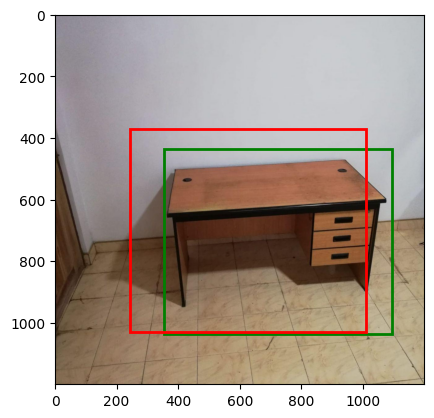

True Box  [353, 437, 1094, 1035]
Predicted Box  [ 61.258293  92.94408  252.27737  257.453   ]


In [17]:
# Load the first row from the validation annotations
row = valid_annotations.iloc[0]

# Set the image path
image_path = os.path.join(data_path, 'valid', row['filename'])

# True bounding box
true_bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]

# Load and preprocess the image
img_array = load_and_preprocess_image(image_path)

# Predict bounding box
pred_bbox = model.predict(img_array)[0]

# Plot true and predicted bounding boxes
plot_bounding_boxes(image_path, true_bbox, pred_bbox*4)
print("True Box ", true_bbox)
print("Predicted Box ", pred_bbox)